# Traitement du Langage Naturel (NLP) : classification de texte


Exemple de classification de texte par LSTM avec pytorch
 

[REQUIREMENTS.txt](#requirements)

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [2]:
df = pd.read_csv('../data/csv-txt/spam/spam.csv', encoding='ISO-8859-1')

In [3]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
# supprimer les colonnes ne comprenant pas de données
cols_to_del = ['Unnamed: 2','Unnamed: 3','Unnamed: 4']
df.drop(cols_to_del, axis=1, inplace=True)

# renommer les colonnes et recoder la target
df.columns = ['label', 'data']
df['b_label'] = df['label'].map({'ham': 0, 'spam':1})

# séparer les données en train et test
df_train, df_test = train_test_split(df, test_size=0.33)

df_train.shape, df_test.shape

((3733, 3), (1839, 3))

In [5]:
# Pre-processing

word2idx = {'<PAD>': 0}

idx = 1

# tokenisation basique
for i, row in df_train.iterrows():
    tokens = row['data'].lower().split()
    for token in tokens:
        if token not in word2idx:
            word2idx[token] = idx
            idx += 1

train_sentences_as_int = []
for i, row in df_train.iterrows():
    tokens = row['data'].lower().split()
    sentence_as_int = [word2idx[token] for token in tokens]
    train_sentences_as_int.append(sentence_as_int)

test_sentences_as_int = []
for i, row in df_test.iterrows():
    tokens = row['data'].lower().split()
    sentence_as_int = [word2idx[token] for token in tokens if token in word2idx]
    test_sentences_as_int.append(sentence_as_int)


# générateur de batchs
def data_generator(X, y, batch_size=32):
    X, y = shuffle(X, y)
    n_batches = int(np.ceil(len(y) / batch_size))

    for i in range(n_batches):
        end = min((i + 1) * batch_size, len(y))

        X_batch = X[i * batch_size:end]
        y_batch = y[i * batch_size:end]

        max_len = np.max([len(x) for x in X_batch])
        for j in range(len(X_batch)):
            x = X_batch[j]
            pad = [0] * (max_len - len(x))
            X_batch[j] = pad + x
        
        X_batch = torch.from_numpy(np.array(X_batch)).long()
        y_batch = torch.from_numpy(np.array(y_batch)).long()

        yield X_batch, y_batch

In [6]:
word2idx

{'<PAD>': 0,
 'boy;': 1,
 'i': 2,
 'love': 3,
 'u': 4,
 'grl:': 5,
 'hogolo': 6,
 'boy:': 7,
 'gold': 8,
 'chain': 9,
 'kodstini': 10,
 'agalla': 11,
 'necklace': 12,
 'madstini': 13,
 'hogli': 14,
 '1': 15,
 'mutai': 16,
 'eerulli': 17,
 'kodthini!': 18,
 'kano;-)': 19,
 'customer': 20,
 'service': 21,
 'announcement.': 22,
 'we': 23,
 'recently': 24,
 'tried': 25,
 'to': 26,
 'make': 27,
 'a': 28,
 'delivery': 29,
 'you': 30,
 'but': 31,
 'were': 32,
 'unable': 33,
 'do': 34,
 'so,': 35,
 'please': 36,
 'call': 37,
 '07099833605': 38,
 're-schedule.': 39,
 'ref:9280114': 40,
 'storming': 41,
 'msg:': 42,
 'wen': 43,
 'lift': 44,
 'd': 45,
 'phne,': 46,
 'say': 47,
 '\\hello\\"': 48,
 'knw': 49,
 'wt': 50,
 'is': 51,
 'real': 52,
 'meaning': 53,
 'of': 54,
 'hello??': 55,
 '.': 56,
 "it's": 57,
 'name': 58,
 'girl..!': 59,
 'yes..': 60,
 'and': 61,
 'who': 62,
 'dat': 63,
 'girl??': 64,
 '\\"margaret': 65,
 'hello\\"': 66,
 'she': 67,
 'girlfrnd': 68,
 'f': 69,
 'grahmbell': 70,
 'inv

In [7]:
# --- Tester notre générateur

for i, t in data_generator(train_sentences_as_int, df_train['b_label']):
    print('inputs:', i,'shape:', i.shape)
    print('targets:', t,'shape:', t.shape)
    break

inputs: tensor([[    0,     0,     0,  ...,     2,   295,   489],
        [    0,     0,     0,  ...,    63,  9623,  9624],
        [   30,   153,   583,  ...,    30,  1497,  4389],
        ...,
        [    0,     0,     0,  ...,  4775,   240,   504],
        [    0,     0,     0,  ...,   999,  1000,  1001],
        [    0,     0,     0,  ...,   239,  2870, 10575]]) shape: torch.Size([32, 43])
targets: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
        0, 1, 1, 0, 1, 0, 1, 0]) shape: torch.Size([32])


In [8]:
# --- Création du modèle RNN (LSTM)

class RNN(nn.Module):
    
    def __init__(self, n_vocab, embed_dim, n_hidden, n_rnnlayers, n_outputs):
        '''
        Constructor for our custom rcnn model
        '''
        super(RNN,self).__init__()
        
        self.V = n_vocab
        self.D = embed_dim
        self.M = n_hidden
        self.K = n_outputs
        self.L = n_rnnlayers

        self.embed = nn.Embedding(self.V, self.D)
        self.rnn = nn.LSTM(
            input_size=self.D,
            hidden_size=self.M,
            num_layers=self.L,
            batch_first=True
        )
        self.dense_layers = nn.Linear(self.M, self.K)
    
    def forward(self, X):
        '''
        Forward pass
        '''
        h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
        c0 = torch.zeros(self.L, X.size(0), self.M).to(device)

        out = self.embed(X)
        out, _ = self.rnn(out, (h0,c0))
        out, _ = torch.max(out, 1)

        out = self.dense_layers(out)

        return out

In [9]:
model = RNN(n_vocab=len(word2idx), embed_dim=20, n_hidden=15, n_rnnlayers=1, n_outputs=1)

In [10]:
# --- GPU

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

model.to(device)

cuda:0


RNN(
  (embed): Embedding(10589, 20)
  (rnn): LSTM(20, 15, batch_first=True)
  (dense_layers): Linear(in_features=15, out_features=1, bias=True)
)

In [11]:
# --- Entraîner le modèle

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

train_gen = lambda: data_generator(train_sentences_as_int, df_train['b_label'])
test_gen = lambda: data_generator(test_sentences_as_int, df_test['b_label'])

def batch_gd(model, criterion, optimizer, epochs):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)

    for it in range(epochs):
        t0 = datetime.now()
        model.train()
        train_loss = []

        for inputs, targets in train_gen():
            targets = targets.view(-1, 1).float()
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())
        
        train_loss = np.mean(train_loss)

        model.eval()
        test_loss = []
        for inputs, targets in test_gen():
            targets = targets.view(-1, 1).float()
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
        
        test_loss = np.mean(test_loss)

        train_losses[it] = train_loss
        test_losses[it] = test_loss

        dt = datetime.now() - t0
        print(f'''Epoch {it+1}/{epochs}\n-----------------
        Train Loss: {train_loss:.4f}
        Test Loss: {test_loss:.4f}
        Duration: {dt}
        ''')
    return train_losses, test_losses

In [12]:
# lancer la boucle d'entraînement
train_losses, test_losses = batch_gd(model, criterion, optimizer, epochs=15)

Epoch 1/15
-----------------
        Train Loss: 0.4417
        Test Loss: 0.3906
        Duration: 0:00:01.244767
        
Epoch 2/15
-----------------
        Train Loss: 0.3574
        Test Loss: 0.3456
        Duration: 0:00:00.583002
        
Epoch 3/15
-----------------
        Train Loss: 0.3009
        Test Loss: 0.2849
        Duration: 0:00:00.548318
        
Epoch 4/15
-----------------
        Train Loss: 0.2357
        Test Loss: 0.2231
        Duration: 0:00:00.626771
        
Epoch 5/15
-----------------
        Train Loss: 0.1763
        Test Loss: 0.1812
        Duration: 0:00:00.664117
        
Epoch 6/15
-----------------
        Train Loss: 0.1346
        Test Loss: 0.1541
        Duration: 0:00:00.662959
        
Epoch 7/15
-----------------
        Train Loss: 0.1062
        Test Loss: 0.1386
        Duration: 0:00:00.595709
        
Epoch 8/15
-----------------
        Train Loss: 0.0874
        Test Loss: 0.1295
        Duration: 0:00:00.665567
        
Epoch 9/

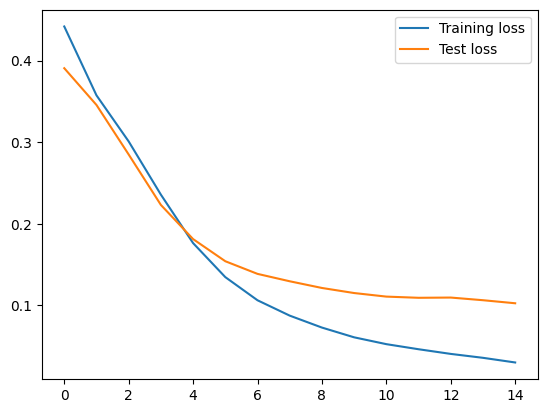

In [13]:
# Loss par itération
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Test loss')
plt.legend()
plt.show()

In [14]:
# Accuracy

model.eval()

# train
n_correct = 0.
n_total = 0.
for inputs, targets in train_gen():
    targets = targets.view(-1, 1).float()
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)
    predictions = (outputs >  0)
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

train_accuracy = n_correct/n_total

# test
n_correct = 0.
n_total = 0.
for inputs, targets in test_gen():
    targets = targets.view(-1, 1).float()
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)
    predictions = (outputs > 0)
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

test_accuracy = n_correct/n_total

print(f'Train accuracy: {train_accuracy:.4f}, Test accuracy: {test_accuracy:.4f}')

Train accuracy: 0.9946, Test accuracy: 0.9744


## <a id="requirements" style="color:black">REQUIREMENTS.txt</a>

<span style="color:orange">Ce notebook a été créé avec python 3.10</span>

Requirements.txt  

```
alembic==1.13.2
aniso8601==9.0.1
anyio==4.4.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
arrow==1.3.0
asttokens==2.4.1
async-lru==2.0.4
attrs==23.2.0
Babel==2.15.0
bcrypt==4.1.3
beautifulsoup4==4.12.3      
bleach==6.1.0
blinker==1.8.2
boto3==1.35.35
botocore==1.35.40
cachetools==5.4.0
certifi==2024.6.2
cffi==1.16.0
charset-normalizer==3.3.2   
click==8.1.7
cloudpickle==3.0.0
colorama==0.4.6
comm==0.2.2
contourpy==1.2.1
cryptography==42.0.8        
cycler==0.12.1
databricks-sdk==0.31.1      
debugpy==1.8.1
decorator==5.1.1
defusedxml==0.7.1
Deprecated==1.2.14
docker==7.1.0
entrypoints==0.4
exceptiongroup==1.2.1
executing==2.0.1
fastjsonschema==2.19.1
filelock==3.13.1
Flask==3.0.3
fonttools==4.53.0
fqdn==1.5.1
fsspec==2024.2.0
gitdb==4.0.11
GitPython==3.1.43
google-auth==2.34.0
graphene==3.3
graphql-core==3.2.3
graphql-relay==3.2.0
greenlet==3.0.3
h11==0.14.0
httpcore==1.0.5
httpx==0.27.0
idna==3.7
imageio==2.35.1
importlib_metadata==7.1.0
intel-openmp==2021.4.0
ipykernel==6.29.4
ipython==8.25.0
ipywidgets==8.1.3
isoduration==20.11.0
itsdangerous==2.2.0
jedi==0.19.1
Jinja2==3.1.3
jmespath==1.0.1
joblib==1.4.2
json5==0.9.25
jsonpointer==3.0.0
jsonschema==4.22.0
jsonschema-specifications==2023.12.1
jupyter==1.0.0
jupyter-console==6.6.3
jupyter-events==0.10.0
jupyter-lsp==2.2.5
jupyter_client==8.6.2
jupyter_core==5.7.2
jupyter_server==2.14.1
jupyter_server_terminals==0.5.3
jupyterlab==4.2.2
jupyterlab_pygments==0.3.0
jupyterlab_server==2.27.2
jupyterlab_widgets==3.0.11
kiwisolver==1.4.5
lazy_loader==0.4
Mako==1.3.5
Markdown==3.6
MarkupSafe==2.1.5
matplotlib==3.9.0
matplotlib-inline==0.1.7
mistune==3.0.2
mkl==2021.4.0
mlflow==2.15.1
mlflow-skinny==2.15.1
mpmath==1.3.0
nbclient==0.10.0
nbconvert==7.16.4
nbformat==5.10.4
nest-asyncio==1.6.0
networkx==3.2.1
notebook==7.2.1
notebook_shim==0.2.4
numpy==1.26.3
opentelemetry-api==1.25.0
opentelemetry-sdk==1.25.0
opentelemetry-semantic-conventions==0.46b0
overrides==7.7.0
packaging==24.1
pandas==2.2.2
pandocfilters==1.5.1
paramiko==3.4.0
parso==0.8.4
pillow==10.2.0
platformdirs==4.2.2
prometheus_client==0.20.0
prompt_toolkit==3.0.47
protobuf==5.28.2
psutil==5.9.8
pure-eval==0.2.2
pyarrow==15.0.2
pyasn1==0.6.0
pyasn1_modules==0.4.0
pycparser==2.22
Pygments==2.18.0
PyNaCl==1.5.0
pyparsing==3.1.2
pysftp==0.2.8
python-dateutil==2.9.0.post0
python-json-logger==2.0.7
pytz==2024.1
pywin32==306
pywinpty==2.0.13
PyYAML==6.0.1
pyzmq==26.0.3
qtconsole==5.5.2
QtPy==2.4.1
querystring-parser==1.2.4
referencing==0.35.1
requests==2.32.3
rfc3339-validator==0.1.4
rfc3986-validator==0.1.1
rpds-py==0.18.1
rsa==4.9
s3transfer==0.10.3
scikit-image==0.24.0
scikit-learn==1.5.1
scipy==1.14.0
Send2Trash==1.8.3
six==1.16.0
smmap==5.0.1
sniffio==1.3.1
soupsieve==2.5
SQLAlchemy==2.0.31
sqlparse==0.5.1
stack-data==0.6.3
sympy==1.12
tbb==2021.11.0
terminado==0.18.1
threadpoolctl==3.5.0
tifffile==2024.9.20
tinycss2==1.3.0
tomli==2.0.1
torch==2.3.1+cu121
torchaudio==2.3.1+cu121
torchvision==0.18.1+cu121
tornado==6.4.1
traitlets==5.14.3
types-python-dateutil==2.9.0.20240316
typing_extensions==4.9.0
tzdata==2024.1
uri-template==1.3.0
urllib3==2.2.1
waitress==3.0.0
wcwidth==0.2.13
webcolors==24.6.0
webencodings==0.5.1
websocket-client==1.8.0
Werkzeug==3.0.3
widgetsnbextension==4.0.11
wrapt==1.16.0
zipp==3.19.2
```